# Multi Needle In A Haystack Evaluation + LangSmith

## Overview

To perform a multi-needle evaluation, you only need three things: 

(1) A `question` that requires multiple needles to answer.

(2) an `answer` derived from the needles.

(3) `list of needles` to be inserted into the context.

The process follows the flow seen here:

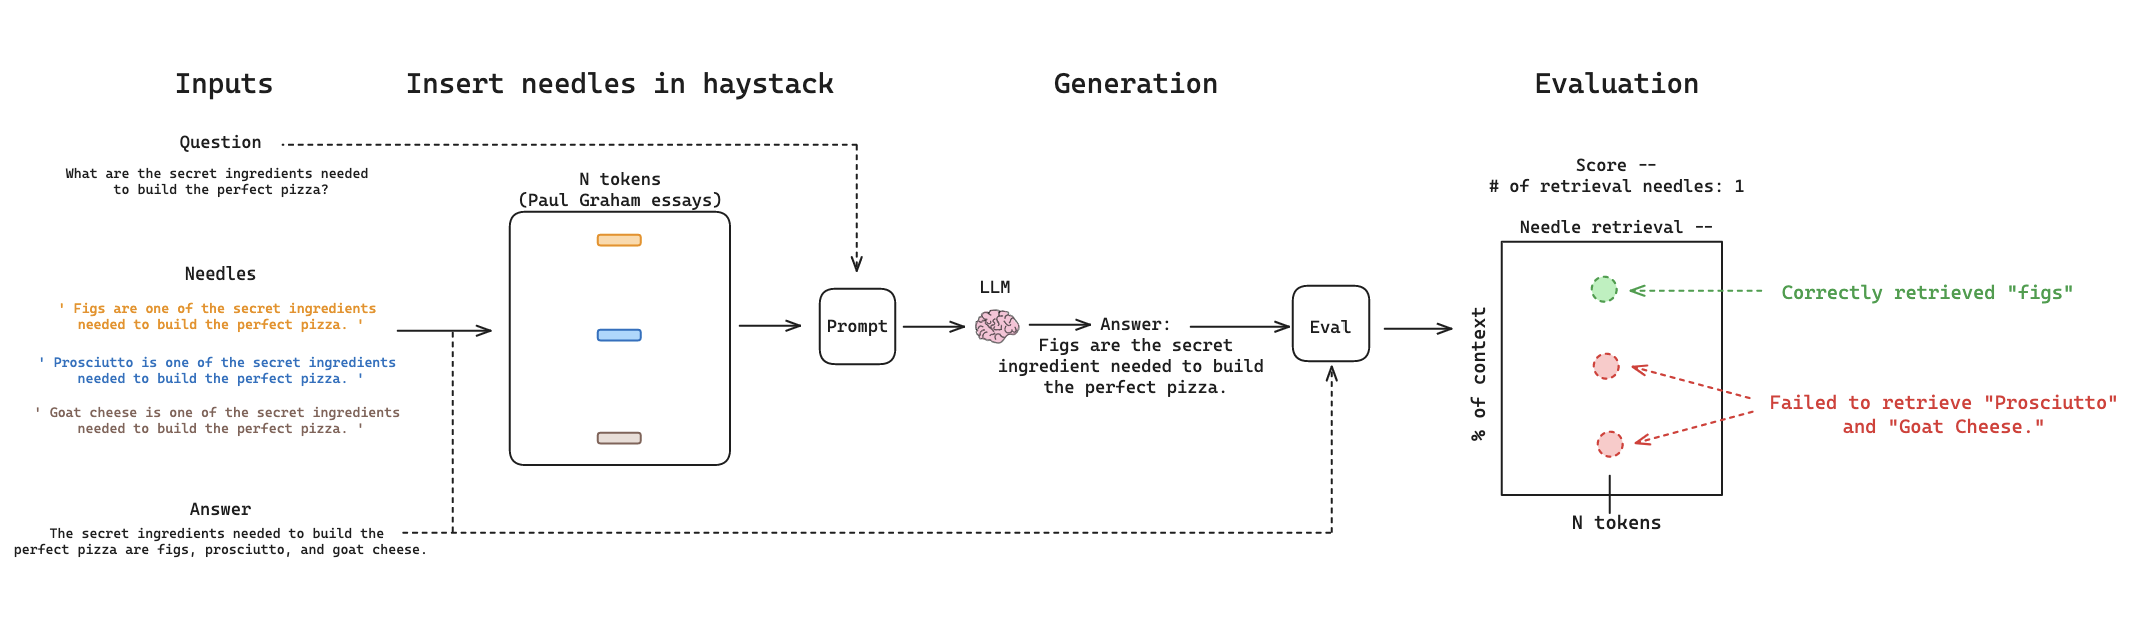

See this video for a full walk-through: TO-ADD

## Eval sets

Add `question` and `answer` to a LangSmith eval set.

As an example, here are the LangSmith eval sets used in this analysis.

* `multi-needle-eval-pizza-1` - https://smith.langchain.com/public/af0f1c89-3993-4ded-91c2-29eebef67582/d
* `multi-needle-eval-pizza-3` - https://smith.langchain.com/public/d6b47e6e-8279-4452-bd22-d6c8b839f1a0/d
* `multi-needle-eval-pizza-10` - https://smith.langchain.com/public/74d2af1c-333d-4a73-87bc-a837f8f0f65c/d

To simply use or inspect the resulting data generated, load the `.csv` files below.

## Run

See full set of commands run for this analysis [here](https://mirror-feeling-d80.notion.site/Multi-Needle-Evaluation-528e8e976a264ef3be2b145003c010e0?pvs=74).

Here is one example:

## Load results

Now, we load our resulst logged to LangSmith from each run.

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

In [64]:
# Eval set names 
eval_sets_retrieval = ["multi-needle-eval-pizza-1",
                       "multi-needle-eval-pizza-3",
                       "multi-needle-eval-pizza-10"]

In [ ]:
import pandas as pd 
from langsmith.client import Client

# LangSmith client
client = Client()

def get_data(eval_sets,model):
    """    
    This function iterates through a list of evaluation sets, querying the LangSmith SDK
    for projects related to each evaluation set. It filters the projects by a specific model name,
    and compiles relevant data into a DataFrame. This includes data about run name, URL, 
    depth percentage, context length, retrieved needles, model name, total needles, answer, 
    needles, and insertion percentages.

    Parameters:
    - eval_sets (list): A list of evaluation set names to query.
    - model (str): The model name to filter the projects by.

    Returns:
    - pd.DataFrame: A DataFrame containing the compiled data from each relevant project.
    """

    # Store
    all_data = []
    
    # Iterate through eval sets 
    for set in eval_sets:

        print(f"Getting data for eval set: {set}")
    
        # All projects in a given eval set
        projects = client.list_projects(reference_dataset_name=set)
        
        # Iterate through the projects
        for p in projects:

            # Each project performs evaluation on all questions
            project = client.read_project(project_name=p.name)

            # Check that needle logging is present and filer on desired model  
            if 'needles' in project.metadata and project.metadata['model_name'] == model:

                # Get each question evaluation in our eval set
                runs = list(client.list_runs(project_id=project.id, execution_order=1))

                print(f"Getting data for run: {p.name}")

                # Get url and ensure its public
                if client.run_is_shared(run_id=runs[0].id):
                    url = client.read_run_shared_link(runs[0].id)    
                else:
                    url = client.share_run(run_id=runs[0].id)   

                # Our eval set only has 1 question, so grab the first / only row
                trace = client.get_test_results(project_name=p.name)
                generation = trace.loc[0,'outputs.output.content']
                
                # Get project metadata
                data = {
                    'run_name': project.name,
                    'run_url': url,
                    'depth %': project.metadata['depth_percent'],
                    'context length': project.metadata['context_length'],
                    'retrieved needles': project.feedback_stats['needles_retrieved']['avg'],
                    'model name': project.metadata['model_name'],
                    'total needles': project.metadata['num_needles'],
                    'answer': generation,
                    'needles': project.metadata['needles'],
                    'insertion_percentages': project.metadata['insertion_percentages']
                }
                
                # Add the data dictionary to the list
                all_data.append(data)
            
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_data)
    return df

# Get data for each LLM
df_gpt4 = get_data(eval_sets_retrieval,"gpt-4-0125-preview")

## Audit LLM grader

We are using GPT-4 as a grader to count the number of retrieved needles in the generation versus the ground truth `answer`. 

We can check the grader by counting the needles specifically using regex. 

This is a useful check, but needs to be tuned for each eval set.

In [3]:
def count_needles(df):

    # Collect the results from all rows in df_model
    all_results = []
    
    # Iterate over each row in df
    for index, row in df.iterrows():

        # Here is relevant metadata
        needle_texts = row['needles']
        run_name = row['run_name']  
        run_url = row['run_url']  
        insertion_percentages = row['insertion_percentages']
        llm_answer = row['answer'] 
        context_size = row['context length']
        retrieved_needles = row['retrieved needles']
        total_needles = row['total needles']
        
        # ** Specific to our question ** 
        # Extract the ingredient names from each sentence in our needles
        # We will search for these ingredients in our generation as a second check
        s1 = " is one of the secret ingredients needed to build the perfect pizza."
        s2 = " are the secret ingredient needed to build the perfect pizza."
        s3 = " are one of the secret ingredients needed to build the perfect pizza."
        needle_points = [sentence.strip().strip().replace(s1, "").replace(s2, "").replace(s3, "") for sentence in needle_texts]
                
        # Check which needle points (ingredient) are in the answer
        for needle_point, insertion_percent, needle_text in zip(needle_points, insertion_percentages, needle_texts):
            present = 1 if needle_point.lower() in llm_answer.lower() else 0
            all_results.append({
                'needle': needle_text,
                'needle point': needle_point,
                'insertion %': insertion_percent,
                'context size': context_size,
                'retrieved_needles_check': present,
                'total_needles':total_needles,
                'run name': run_name,
                'run_url': run_url,
                'retrieved_needles':retrieved_needles
            })
    
    return pd.DataFrame(all_results)

# Verify results
df_gpt4_needle_check=count_needles(df_gpt4)

Now, we can simply look for cases where the LLM grader and our manual counting differ.

We can see that this seems to happen when the number of needles is large (10).

In [70]:
def find_traces_to_audit(df):
    
    check_df=df.groupby(['run name',
                         'retrieved_needles',
                         'total_needles'])['retrieved_needles_check'].sum().reset_index()
    
    to_audit = check_df[check_df['retrieved_needles'] != check_df['retrieved_needles_check']]
    check = [to_audit.loc[i,'run name'] for i in to_audit.index]
    print(f'Check these runs: {check}')
    return to_audit

d_fix_gpt4=find_traces_to_audit(df_gpt4_needle_check)

Check these runs: ['120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--256b', '120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--9311', '120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--a958', '24800-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--e6ae', '48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--12d7', '48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--6323', '48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--7837', '48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--aa1e', '48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--bdef', '72400-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--1229']


Audit using LangSmith traces [here](https://smith.langchain.com/public/74d2af1c-333d-4a73-87bc-a837f8f0f65c/d?paginationState=%7B%22pageIndex%22%3A0%2C%22pageSize%22%3A50%7D&chartedColumn=latency_p50) confirms the manual check:

* `120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--256b` -- Grader counts `espresso-soaked dates` twice. Confirm: `6`.
* `120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--a958` -- Grader counts `espresso-soaked dates` twice. Confirm: `6`.
* `24800-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--e6ae`-- Grader mistake (answer contains duplicates). Confirm: `7`.
* `48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--12d7` -- Grader miscounts 5 as 6. Confirm: `5`.

We defer to our counting method in cases where the grader does not agree.

In [ ]:
def update_retrieved_needles(df, run_name, retrieved_needles_corrected):
    """
    Updates the 'retrieved needles' values for a specific run_name in the DataFrame.

    Parameters:
    - df: The pandas DataFrame containing the data.
    - run_name: The name of the run to update.
    - retrieved_needles_corrected: The corrected value for 'retrieved needles'.
    """
    # Check if run_name exists in the DataFrame
    if run_name in df['run_name'].values:
        # Update 'retrieved needles' where 'run_name' matches
        df.loc[df['run_name'] == run_name, 'retrieved needles'] = retrieved_needles_corrected
        print(f"Updated 'retrieved needles' for run_name '{run_name}' to {retrieved_needles_corrected}.")
    else:
        print(f"Run name '{run_name}' not found in DataFrame.")

for ix, row in d_fix_gpt4.iterrows():
    # The counts from manual check are confirmed correct
    update_retrieved_needles(df_gpt4,row['run name'],row['retrieved_needles_check'])

In [223]:
df_gpt4.to_csv("multi-needle-datasets/gpt4_retrieval.csv")
df_gpt4_needle_check.to_csv("multi-needle-datasets/gpt4_retrieval_per_needle.csv")

In [224]:
df_gpt4.groupby(['context length','total needles'])['run_name'].nunique()

context length  total needles
1000            1                3
                3                5
                10               9
24800           1                3
                3                5
                10               9
48600           1                3
                3                5
                10               9
72400           1                3
                3                5
                10               9
96200           1                3
                3                5
                10               9
120000          1                3
                3                5
                10               9
Name: run_name, dtype: int64

## Load and plot retrieval data

If you simply want to test the below code, start here.

In [225]:
import ast
df_gpt4=pd.read_csv("multi-needle-datasets/gpt4_retrieval.csv")
df_gpt4_needle_check=pd.read_csv("multi-needle-datasets/gpt4_retrieval_per_needle.csv")
df_gpt4['needles'] = df_gpt4['needles'].apply(lambda x: ast.literal_eval(x))
df_gpt4['insertion_percentages'] = df_gpt4['insertion_percentages'].apply(lambda x: ast.literal_eval(x))

## Plot retrieval wrt needle count

Compute fraction of retrieval needles per model, context length, and # of needles. Compute across all replicates.

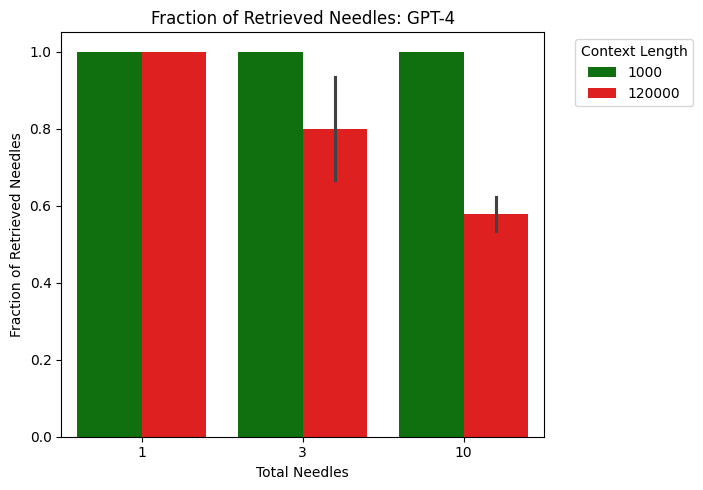

In [226]:
import warnings

def plot_performance_vs_needles(df):
    with warnings.catch_warnings():
        
    # Ignore specific FutureWarnings
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        plt.figure(figsize=(8, 5))  
        ax = sns.barplot(data=df, 
                         x='total needles', 
                         y='fract per turn', 
                         hue='context length', 
                         palette=['green', 'red'])
        ax.set_title('Fraction of Retrieved Needles: GPT-4')
        ax.set_xlabel('Total Needles')
        ax.set_ylabel('Fraction of Retrieved Needles')
        ax.grid(False)
        ax.legend(title='Context Length', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.savefig("retrieval_barplot.png", dpi=300, bbox_inches='tight')
        plt.show()

# Prepare for plotting
df_gpt4['fract per turn'] = df_gpt4['retrieved needles'] / df_gpt4['total needles']

# Choose specific context lengths to plot
df_gpt4_plot = df_gpt4[df_gpt4['context length'].isin([120000,1000])]

plot_performance_vs_needles(df_gpt4_plot)

## Plot retrieval wrt position

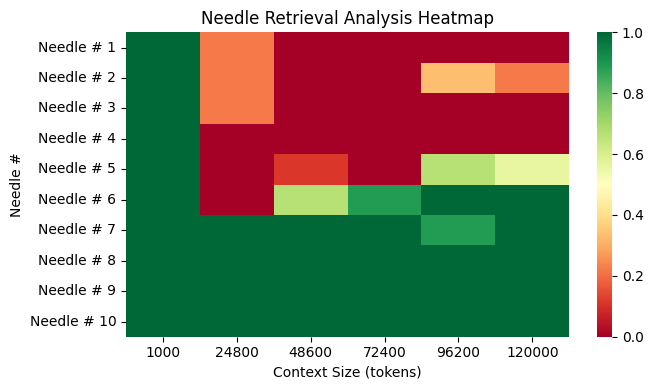

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Number of needles to focus on
number_of_needles = 10
d_for_headmap = df_gpt4_needle_check[df_gpt4_needle_check.total_needles == number_of_needles].copy()

# Label each needle
s = d_for_headmap[d_for_headmap['context size']==d_for_headmap['context size'].unique()[0]]
s = s[['needle','insertion %']].drop_duplicates()
needle_names = [f"Needle # {int(s)}" for s in np.linspace(1,number_of_needles,number_of_needles)]
s['needle_name'] = needle_names
s.set_index('needle',inplace=True)
d_for_headmap['needle_name'] = d_for_headmap['needle'].apply(lambda x: s.loc[x,'needle_name'])

# Group by 'total_needles' and 'context size' and calculate the mean 'insertion %'
heatmap_data = d_for_headmap.groupby(['needle_name', 'context size'])['retrieved_needles_check'].mean().reset_index()

# Correcting the pivot call
heatmap_data_pivoted = heatmap_data.pivot(index="needle_name", columns="context size", values="retrieved_needles_check")

# Now, plot the heatmap
plt.figure(figsize=(7, 4)) 
sns.heatmap(heatmap_data_pivoted.loc[needle_names], annot=False, cmap="RdYlGn", fmt=".2f", linewidths=0.0)

plt.title('Needle Retrieval Analysis Heatmap')
plt.xlabel('Context Size (tokens)')
plt.ylabel('Needle #')
plt.tight_layout()
plt.savefig("retrieval_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot retrieval vs reasoning

`eval_sets_reasoning`

* https://smith.langchain.com/public/a85db85f-ee45-4a39-a1ac-52f7279134ac/d
* https://smith.langchain.com/public/270cd9cd-154d-4ba9-8b34-7b6537007867/d
* https://smith.langchain.com/public/00658b64-6199-48fc-9443-1478aadbe19a/d

In [ ]:
# Get data
eval_sets_reasoning = ["multi-needle-eval-pizza-reasoning-1",
                       "multi-needle-eval-pizza-reasoning-3",
                       "multi-needle-eval-pizza-reasoning-10"]

df_gpt4_reasoning = get_data(eval_sets_reasoning,"gpt-4-0125-preview")

In [228]:
df_gpt4_reasoning.groupby(['context length','total needles'])['run_name'].nunique()

context length  total needles
1000            1                3
                3                3
                10               4
120000          1                5
                3                6
                10               7
Name: run_name, dtype: int64

In [229]:
# Manual audit of grader
update_retrieved_needles(df_gpt4_reasoning,'120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--4506', 5)
update_retrieved_needles(df_gpt4_reasoning,'120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--daf3', 5)
update_retrieved_needles(df_gpt4_reasoning,'120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--1da7', 5)

# Set stat
df_gpt4_reasoning['fract per turn'] = df_gpt4_reasoning['retrieved needles'] / df_gpt4_reasoning['total needles']
df_gpt4_reasoning.to_csv("multi-needle-datasets/gpt4_reasoning.csv")

Updated 'retrieved needles' for run_name '120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--4506' to 5.
Updated 'retrieved needles' for run_name '120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--daf3' to 5.
Updated 'retrieved needles' for run_name '120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--1da7' to 5.


In [230]:
df_gpt4_reasoning = pd.read_csv("multi-needle-datasets/gpt4_reasoning.csv")

In [231]:
# Combine
df_gpt4_retrieval = df_gpt4.copy()
df_gpt4_retrieval['mode'] = 'retrieval'
df_gpt4_reasoning['mode'] = 'reasoning'
combined = pd.concat([df_gpt4_retrieval,df_gpt4_reasoning],axis=0)

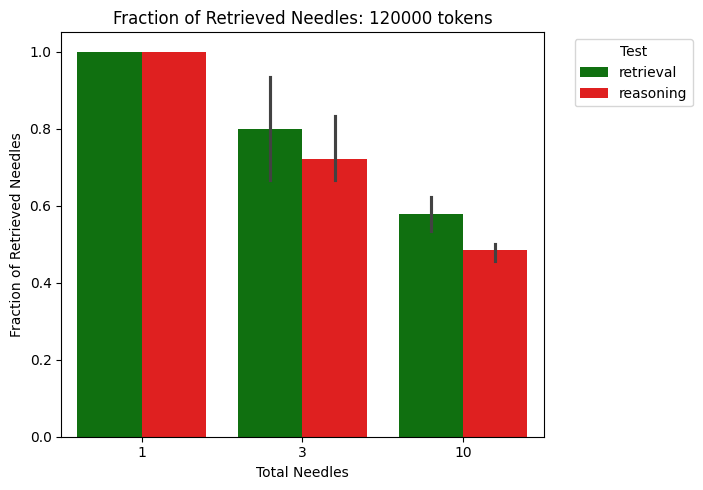

In [232]:
def plot_reasoning_performance_vs_needles(df,context_length):
    with warnings.catch_warnings():
        
    # Ignore specific FutureWarnings
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        plt.figure(figsize=(8, 5))  
        ax = sns.barplot(data=df, 
                         x='total needles', 
                         y='fract per turn', 
                         hue='mode', 
                         palette=['green', 'red'])
        ax.set_title(f'Fraction of Retrieved Needles: {context_length} tokens')
        ax.set_xlabel('Total Needles')
        ax.set_ylabel('Fraction of Retrieved Needles')
        ax.grid(False)
        ax.legend(title='Test', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.savefig("retrieval_reasoning.png", dpi=300, bbox_inches='tight')
        plt.show()

context_length = 120000
plot_reasoning_performance_vs_needles(combined[combined['context length']==context_length],context_length)